**ECG Heartbeat Classification: A Deep Transferable Representation**::

In [1]:
!nvidia-smi

Wed Jan 26 11:16:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install tensorflow-addons==0.8.3

     |████████████████████████████████| 1.0 MB 8.3 MB/s 


In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
import sklearn
import itertools
from tensorflow_addons.optimizers import CyclicalLearningRate
import matplotlib as mpl
mpl.style.use('seaborn')

# Move data from Drive to /tmp

In [4]:
# You can obtain the data from Kaggle at https://www.kaggle.com/shayanfazeli/heartbeat
from google.colab import drive
drive.mount("/tmp/drive")

Mounted at /tmp/drive


In [6]:
! unzip "/tmp/drive/My Drive/ecg.zip" -d /tmp/ecg
! ls /tmp/ecg

Archive:  /tmp/drive/My Drive/ecg.zip
 extracting: /tmp/ecg/mitbih_test.csv.zip  
 extracting: /tmp/ecg/ptbdb_abnormal.csv.zip  
 extracting: /tmp/ecg/ptbdb_normal.csv.zip  
 extracting: /tmp/ecg/mitbih_train.csv.zip  
mitbih_test.csv.zip   ptbdb_abnormal.csv.zip
mitbih_train.csv.zip  ptbdb_normal.csv.zip


# Import and analyse data
## MIT-BIH Arhythmia dataset

In [7]:
ls /tmp/ecg

mitbih_test.csv.zip   ptbdb_abnormal.csv.zip
mitbih_train.csv.zip  ptbdb_normal.csv.zip


In [8]:
mitbih_test = pd.read_csv("/tmp/ecg/mitbih_test.csv.zip", header=None)
mitbih_train = pd.read_csv("/tmp/ecg/mitbih_train.csv.zip", header=None)

In [9]:
mitbih_train.shape

(87554, 188)

In [10]:
mitbih_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,0.044118,0.061275,0.066176,0.061275,0.049020,0.073529,0.061275,0.061275,0.066176,0.068627,0.095588,0.075980,0.093137,0.105392,0.115196,0.102941,0.117647,0.125000,0.142157,0.127451,0.151961,0.144608,0.164216,0.144608,0.159314,0.151961,0.154412,0.142157,0.151961,0.151961,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,0.074074,0.062678,0.065527,0.065527,0.062678,0.076923,0.071225,0.082621,0.091168,0.096866,0.082621,0.082621,0.091168,0.105413,0.122507,0.148148,0.182336,0.193732,0.213675,0.207977,0.222222,0.253561,0.270655,0.287749,0.284900,0.293447,0.256410,0.247863,0.188034,0.145299,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,0.056757,0.043243,0.067568,0.062162,0.078378,0.072973,0.086486,0.081081,0.108108,0.110811,0.135135,0.135135,0.170270,0.183784,0.216216,0.237838,0.270270,0.286486,0.316216,0.318919,0.332432,0.297297,0.267568,0.216216,0.189189,0.132432,0.118919,0.064865,0.064865,0.043243,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,0.063536,0.082873,0.085635,0.093923,0.113260,0.124309,0.140884,0.132597,0.140884,0.091160,0.085635,0.074586,0.071823,0.080110,0.096685,0.118785,0.138122,0.140884,0.138122,0.146409,0.110497,0.102210,0.060773,0.027624,0.038674,0.013812,0.011050,0.013812,0.033149,0.005525,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,0.131455,0.122066,0.140845,0.159624,0.150235,0.145540,0.136150,0.169014,0.178404,0.173709,0.183099,0.201878,0.187793,0.164319,0.187793,0.215962,0.215962,0.201878,0.211268,0.230047,0.215962,0.230047,0.239437,0.267606,0.253521,0.230047,0.220657,0.225352,0.211268,0.173709,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Explore feature and label distribution


    0: "Normal",
    1: "Artial Premature",
    2: "Premature ventricular contraction",
    3: "Fusion of ventricular and normal",
    4: "Fusion of paced and normal"



In [11]:
mitbih_labels = {'N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4}
mitbih_reverse_labels = {v:k for k,v in mitbih_labels.items()}
mitbih_train_labels = mitbih_train.iloc[:,-1].replace(mitbih_reverse_labels)

In [13]:
mitbih_reverse_labels

{0: 'N', 1: 'S', 2: 'V', 3: 'F', 4: 'Q'}

In [14]:
mitbih_train_labels

0        N
1        N
2        N
3        N
4        N
        ..
87549    Q
87550    Q
87551    Q
87552    Q
87553    Q
Name: 187, Length: 87554, dtype: object

Text(0.5, 1.0, 'Distribution of labels in MIT-BIH Arhythmia dataset')

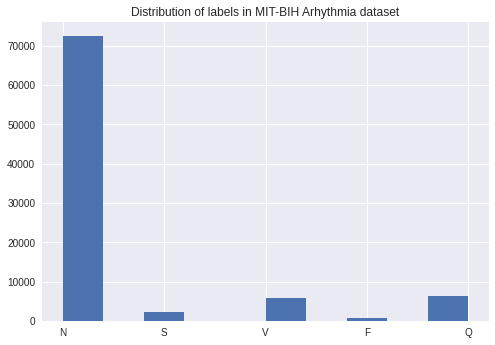

In [15]:
plt.hist(mitbih_train_labels)
plt.title("Distribution of labels in MIT-BIH Arhythmia dataset")

Text(0.5, 1.0, 'MIT-BIH Arrhythmia Dataset example signal')

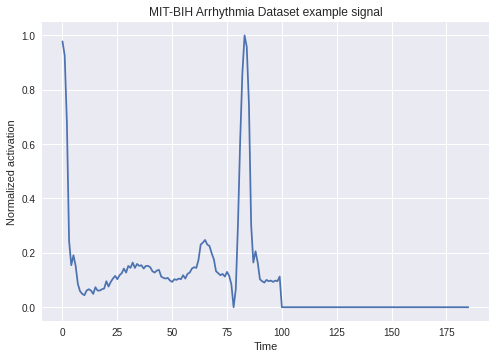

In [16]:
plt.plot(mitbih_train.iloc[0,:-2]) ## excluding label data 
plt.xlabel('Time')
plt.ylabel('Normalized activation')
plt.title("MIT-BIH Arrhythmia Dataset example signal")

### Explore data quality

In [17]:
print("There are {} nan values in the train data.".format(mitbih_train.isna().sum().sum()))
print("There are {} nan values in the test data.".format(mitbih_test.isna().sum().sum()))

There are 0 nan values in the train data.
There are 0 nan values in the test data.


In [18]:
print("The minimum and maximum values are {}, {}".format(np.min(mitbih_train.iloc[:,:-2].values), np.max(mitbih_train.iloc[:,:-2].values)))

The minimum and maximum values are 0.0, 1.0


## PTB Diagnostic ECG Database

In [19]:
ptbdb_abnormal = pd.read_csv("/tmp/ecg/ptbdb_abnormal.csv.zip", header=None)
ptbdb_normal = pd.read_csv("/tmp/ecg/ptbdb_normal.csv.zip", header=None)
ptbdb = pd.concat([ptbdb_abnormal, ptbdb_normal], axis=0, ignore_index=True)

In [20]:
ptbdb.shape

(14552, 188)

In [21]:
ptbdb.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187
0,0.932233,0.869679,0.886186,0.929626,0.908775,0.933970,0.801043,0.749783,0.687229,0.635100,0.649870,0.635100,0.655083,0.664639,0.633362,0.746308,0.871416,0.938314,1.000000,0.948740,0.396177,0.000000,0.039096,0.128584,0.305821,0.640313,0.617724,0.537793,0.352737,0.220678,0.256299,0.357950,0.482189,0.570808,0.577758,0.620330,0.622068,0.618593,0.626412,0.612511,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.000000,0.606941,0.384181,0.254237,0.223567,0.276836,0.253430,0.184826,0.153349,0.121872,0.125101,0.129136,0.137207,0.137207,0.132365,0.126715,0.158192,0.152542,0.132365,0.168684,0.156578,0.183212,0.191283,0.204197,0.230024,0.244552,0.285714,0.307506,0.321227,0.327684,0.351897,0.373688,0.397094,0.363196,0.340597,0.307506,0.258273,0.197740,0.199354,0.173527,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.000000,0.951613,0.923963,0.853303,0.791859,0.734255,0.672043,0.685100,0.670507,0.667435,0.681260,0.616743,0.624424,0.619816,0.596006,0.627496,0.631336,0.619048,0.612903,0.613671,0.607527,0.586790,0.568356,0.543779,0.526882,0.552995,0.577573,0.592166,0.576037,0.579109,0.573733,0.589862,0.542243,0.519201,0.514593,0.528418,0.493856,0.485407,0.461598,0.478495,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.977819,0.899261,0.230129,0.032348,0.142329,0.223660,0.328096,0.367837,0.381701,0.389094,0.357671,0.379852,0.375231,0.397412,0.388170,0.378004,0.398336,0.419593,0.427911,0.402033,0.378928,0.400185,0.406654,0.422366,0.402033,0.383549,0.398336,0.393715,0.417745,0.388170,0.360444,0.402957,0.392791,0.413124,0.377079,0.327172,0.346580,0.338262,0.356747,0.314233,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.935618,0.801661,0.805815,1.000000,0.722741,0.480789,0.454829,0.319834,0.266874,0.308411,0.285566,0.343718,0.281412,0.281412,0.283489,0.281412,0.319834,0.311526,0.283489,0.278297,0.274143,0.317757,0.267913,0.275182,0.280374,0.255452,0.313603,0.266874,0.244029,0.198339,0.192108,0.190031,0.134995,0.086189,0.078920,0.036345,0.024922,0.000000,0.044652,0.024922,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [22]:
ptbdb_abnormal.values[:,-1] # Abnormal is labelled one as per convention

array([1., 1., 1., ..., 1., 1., 1.])

### Explore features and labels

In [24]:
ptbdb_labels = {'Normal': 0, 'Abnormal': 1}
ptbdb_reverse_labels = {v:k for k,v in ptbdb_labels.items()}
ptbdb_labels = ptbdb.iloc[:,-1].replace(ptbdb_reverse_labels)

Text(0.5, 1.0, 'Distribution of the PTB Diagnostic ECG Database labels')

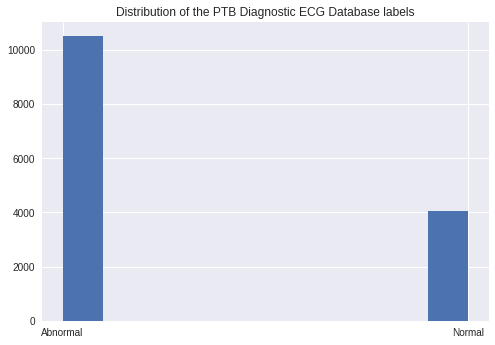

In [25]:
plt.hist(ptbdb_labels)
plt.title("Distribution of the PTB Diagnostic ECG Database labels")

### Explore data quality

In [26]:
print("There are {} nan values in the train data.".format(mitbih_train.isna().sum().sum()))
print("There are {} nan values in the test data.".format(mitbih_test.isna().sum().sum()))

There are 0 nan values in the train data.
There are 0 nan values in the test data.


In [27]:
print("The minimum and maximum values are {}, {}".format(np.min(ptbdb.iloc[:,:-2].values), np.max(ptbdb.iloc[:,:-2].values)))

The minimum and maximum values are 0.0, 1.0


Text(0.5, 1.0, 'PTB Diagnostic ECG Database example signal')

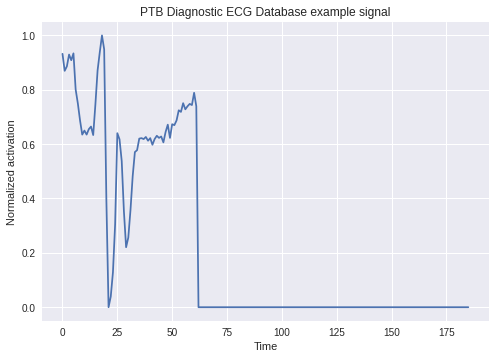

In [32]:
plt.plot(ptbdb.iloc[0,:-2])
plt.xlabel('Time')
plt.ylabel('Normalized activation')
plt.title("PTB Diagnostic ECG Database example signal")

# Fixed Helper functions

In [33]:
# Copied from https://github.com/avanwyk/tensorflow-projects/blob/master/lr-finder/lr_finder.py
# Apache License 2.0

from tensorflow.keras.callbacks import Callback

class LRFinder(Callback):
    """`Callback` that exponentially adjusts the learning rate after each training batch between `start_lr` and
    `end_lr` for a maximum number of batches: `max_step`. The loss and learning rate are recorded at each step allowing
    visually finding a good learning rate as per https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html via
    the `plot` method.
    """

    def __init__(self, start_lr: float = 1e-7, end_lr: float = 10, max_steps: int = 100, smoothing=0.9):
        super(LRFinder, self).__init__()
        self.start_lr, self.end_lr = start_lr, end_lr
        self.max_steps = max_steps
        self.smoothing = smoothing
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_begin(self, logs=None):
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_batch_begin(self, batch, logs=None):
        self.lr = self.exp_annealing(self.step)
        tf.keras.backend.set_value(self.model.optimizer.lr, self.lr)

    def on_train_batch_end(self, batch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        step = self.step
        if loss:
            self.avg_loss = self.smoothing * self.avg_loss + (1 - self.smoothing) * loss
            smooth_loss = self.avg_loss / (1 - self.smoothing ** (self.step + 1))
            self.losses.append(smooth_loss)
            self.lrs.append(self.lr)

            if step == 0 or loss < self.best_loss:
                self.best_loss = loss

            if smooth_loss > 4 * self.best_loss or tf.math.is_nan(smooth_loss):
                self.model.stop_training = True

        if step == self.max_steps:
            self.model.stop_training = True

        self.step += 1

    def exp_annealing(self, step):
        return self.start_lr * (self.end_lr / self.start_lr) ** (step * 1. / self.max_steps)

    def plot(self):
        fig, ax = plt.subplots(1, 1)
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate (log scale)')
        ax.set_xscale('log')
        ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))
        ax.plot(self.lrs, self.losses)

In [34]:
def pretty_plot(history, field, fn):
  def plot(data, val_data, best_index, best_value, title):
    plt.plot(range(1, len(data)+1), data, label='train')
    plt.plot(range(1, len(data)+1), val_data, label='validation')
    if not best_index is None:
      plt.axvline(x=best_index+1, linestyle=':', c="#777777")
    if not best_value is None:
      plt.axhline(y=best_value, linestyle=':', c="#777777")
    plt.xlabel('Epoch')
    plt.ylabel(field)
    plt.xticks(range(0, len(data), 20))
    plt.title(title)
    plt.legend()
    plt.show()

  data = history.history[field]
  val_data = history.history['val_' + field]
  tail = int(0.15 * len(data))

  best_index = fn(val_data)
  best_value = val_data[best_index]

  plot(data, val_data, best_index, best_value, "{} over epochs (best {:06.4f})".format(field, best_value))
  plot(data[-tail:], val_data[-tail:], None, best_value, "{} over last {} epochs".format(field, tail))

In [35]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Baseline MLP

In [36]:
def get_base_model(categories=2):
  return keras.Sequential([
    keras.layers.Dense(15, activation='relu', input_shape=[187], kernel_regularizer=regularizers.l2(0.0001)),
    keras.layers.Dense(10, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    keras.layers.Dense(5, activation='relu'),
    (keras.layers.Dense(1, activation='sigmoid') if categories == 2 else keras.layers.Dense(5, activation='softmax'))                   
  ])

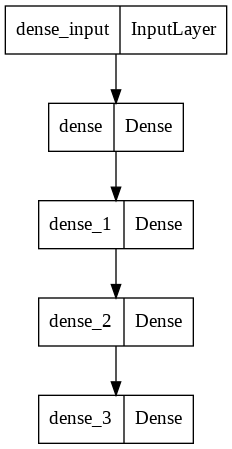

In [37]:
tf.keras.utils.plot_model(
    get_base_model(),
    to_file="model.png")

## Baseline PTB check

In [38]:
X_ptbdb_train, X_ptbdb_val, y_ptbdb_train, y_ptbdb_val = train_test_split(ptbdb.iloc[:,:-1].values, ptbdb.iloc[:,-1].values, test_size=0.2, random_state=42)
X_ptbdb_val, X_ptbdb_test, y_ptbdb_val, y_ptbdb_test  = train_test_split(X_ptbdb_val, y_ptbdb_val, test_size=0.5, random_state=42)

print("All features size {}".format(ptbdb.iloc[:,:-1].shape))
print("Train features size {}".format(X_ptbdb_train.shape))
print("Validation features size {}".format(X_ptbdb_val.shape))
print("Test features size {}".format(X_ptbdb_test.shape))

All features size (14552, 187)
Train features size (11641, 187)
Validation features size (1455, 187)
Test features size (1456, 187)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


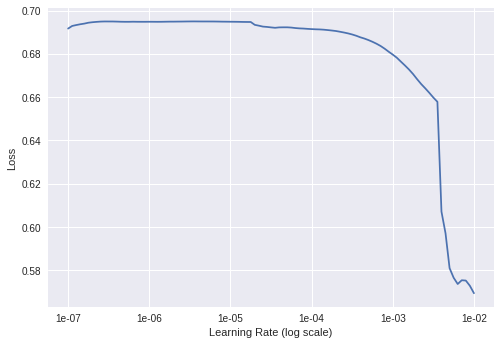

In [39]:
optimizer = keras.optimizers.Adam(lr=0.001)
model = get_base_model() 
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

lr_finder = LRFinder(start_lr=1e-7, end_lr= 1e-2, max_steps=100, smoothing=0.6)
_ = model.fit(X_ptbdb_train, y_ptbdb_train, batch_size=256, epochs=5, callbacks=[lr_finder], verbose=False)
lr_finder.plot()

In [45]:
# Set cyclical learning rate
N = X_ptbdb_train.shape[0] ## 11641
batch_size = 128
iterations = N/batch_size   ## 90.9453125
step_size= 2 * iterations   ## 181.890625
lr_schedule = CyclicalLearningRate(1e-4, 1e-2, step_size=step_size, scale_fn=lambda x: tf.pow(0.95,x))
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

save_best_weights = ModelCheckpoint(filepath="weights.hdf5", verbose=0, save_best_only=True)

base_model = get_base_model() 
base_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
history = base_model.fit(X_ptbdb_train, y_ptbdb_train, validation_data=(X_ptbdb_val, y_ptbdb_val), 
                         shuffle=True, batch_size=batch_size, epochs=30, callbacks=[save_best_weights])

Epoch 1/30
91/91 [==============================] - 1s 5ms/step - loss: 0.5560 - accuracy: 0.7196 - val_loss: 0.4387 - val_accuracy: 0.7924
Epoch 2/30
91/91 [==============================] - 0s 4ms/step - loss: 0.3955 - accuracy: 0.8114 - val_loss: 0.3786 - val_accuracy: 0.8213
Epoch 3/30
91/91 [==============================] - 0s 4ms/step - loss: 0.3345 - accuracy: 0.8504 - val_loss: 0.3458 - val_accuracy: 0.8316
Epoch 4/30
91/91 [==============================] - 0s 4ms/step - loss: 0.2973 - accuracy: 0.8705 - val_loss: 0.2902 - val_accuracy: 0.8715
Epoch 5/30
91/91 [==============================] - 0s 4ms/step - loss: 0.2690 - accuracy: 0.8884 - val_loss: 0.2852 - val_accuracy: 0.8729
Epoch 6/30
91/91 [==============================] - 0s 3ms/step - loss: 0.2715 - accuracy: 0.8836 - val_loss: 0.3703 - val_accuracy: 0.8378
Epoch 7/30
91/91 [==============================] - 0s 4ms/step - loss: 0.2616 - accuracy: 0.8909 - val_loss: 0.2612 - val_accuracy: 0.8914
Epoch 8/30
91/91 [==

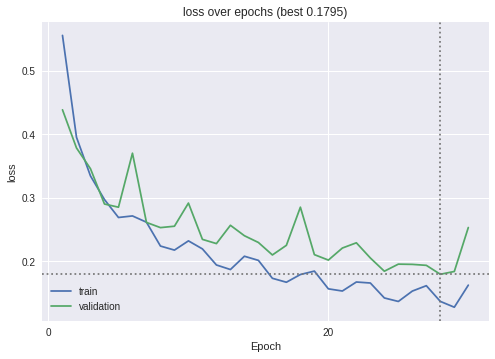

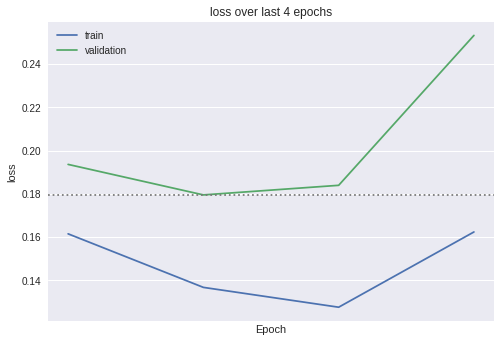

In [46]:
## Loss over epochs
pretty_plot(history, 'loss', lambda x: np.argmin(x))

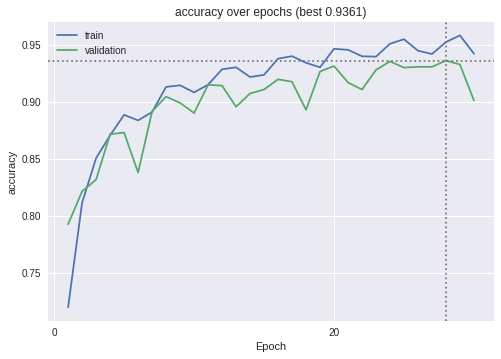

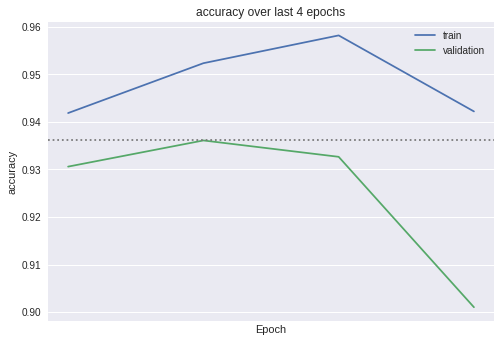

In [47]:
## Accuracy
pretty_plot(history, 'accuracy', lambda x: np.argmax(x))

In [48]:
base_model.load_weights('weights.hdf5')
base_model.evaluate(X_ptbdb_test, y_ptbdb_test)   ## [0.14557285606861115, 0.9505494236946106]

46/46 [==============================] - 0s 2ms/step - loss: 0.1456 - accuracy: 0.9505


[0.14557285606861115, 0.9505494236946106]

In [49]:
y_pred = (base_model.predict(X_ptbdb_test) > 0.5).astype("int32")
y_pred

array([[1],
       [1],
       [0],
       ...,
       [1],
       [1],
       [1]], dtype=int32)

Confusion matrix, without normalization
[[ 351   34]
 [  38 1033]]


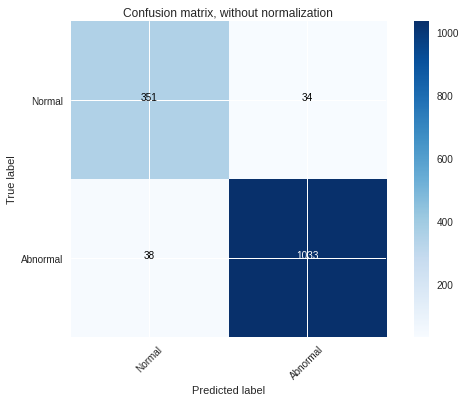

In [50]:
# Compute confusion matrix
cnf_matrix = sklearn.metrics.confusion_matrix(y_ptbdb_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Normal', 'Abnormal'],
                      title='Confusion matrix, without normalization')

# ResNet model

**Model Structure**

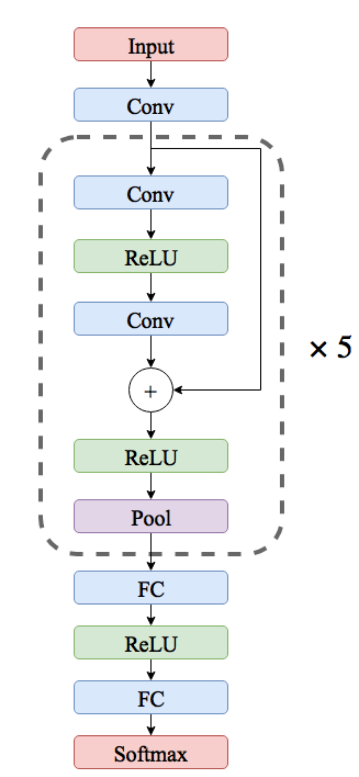

In [51]:
def get_resnet_model(categories=2):
  def residual_block(X, kernels, stride):
    out = keras.layers.Conv1D(kernels, stride, padding='same')(X)
    out = keras.layers.ReLU()(out)
    out = keras.layers.Conv1D(kernels, stride, padding='same')(out)
    out = keras.layers.add([X, out])
    out = keras.layers.ReLU()(out)
    out = keras.layers.MaxPool1D(5, 2)(out)
    return out

  kernels = 32
  stride = 5

  inputs = keras.layers.Input([187,1])
  X = keras.layers.Conv1D(kernels, stride)(inputs)
  ## residual_block * 5 repetition
  X = residual_block(X, kernels, stride)
  X = residual_block(X, kernels, stride)
  X = residual_block(X, kernels, stride)
  X = residual_block(X, kernels, stride)
  X = residual_block(X, kernels, stride)
  X = keras.layers.Flatten()(X)
  X = keras.layers.Dense(32, activation='relu')(X)
  X = keras.layers.Dense(32, activation='relu')(X)
  output = (keras.layers.Dense(1, activation='sigmoid')(X) if categories == 2 else keras.layers.Dense(5, activation='softmax')(X))
  ## caegories(label) 2-> sigmoid(binary classification), label caegories->5 softmax 
  model = keras.Model(inputs=inputs, outputs=output) 
  return model

## ResNet PTB replication

In [52]:
X_ptbdbl_train = np.expand_dims(X_ptbdb_train, -1)
y_ptbdbl_train = np.expand_dims(y_ptbdb_train, -1)

X_ptbdbl_val = np.expand_dims(X_ptbdb_val, -1)
y_ptbdbl_val = np.expand_dims(y_ptbdb_val, -1)

X_ptbdbl_test = np.expand_dims(X_ptbdb_test, -1)
y_ptbdbl_test = np.expand_dims(y_ptbdb_test, -1)

In [53]:
X_ptbdbl_train.shape ## (11641, 187, 1)

(11641, 187, 1)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


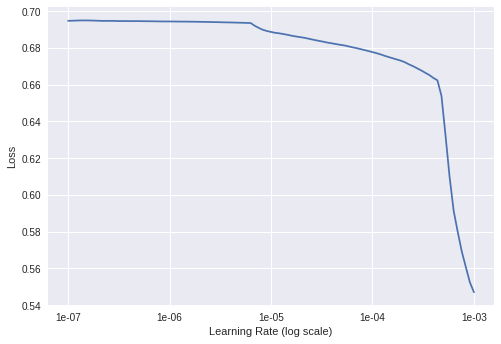

In [54]:
optimizer = keras.optimizers.Adam(lr=0.001)
model = get_resnet_model() 
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

lr_finder = LRFinder(start_lr=1e-7, end_lr= 1e-03, max_steps=100, smoothing=0.6)
_ = model.fit(X_ptbdbl_train, y_ptbdbl_train, batch_size=256, epochs=5, callbacks=[lr_finder], verbose=False)
lr_finder.plot()

In [55]:
# Set cyclical learning rate
N = X_ptbdbl_train.shape[0]
batch_size = 128
iterations = N/batch_size
step_size= 2 * iterations

lr_schedule = CyclicalLearningRate(1e-6, 1e-3, step_size=step_size, scale_fn=lambda x: tf.pow(0.95,x))
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

save_best_weights = ModelCheckpoint(filepath="weights.hdf5", verbose=0, save_best_only=True)

resnet_model = get_resnet_model() 
resnet_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
history = resnet_model.fit(X_ptbdbl_train, y_ptbdbl_train, validation_data=(X_ptbdbl_val, y_ptbdbl_val), 
                           shuffle=True, batch_size=batch_size, epochs=20, callbacks=[save_best_weights])

Epoch 1/20
91/91 [==============================] - 4s 15ms/step - loss: 0.5665 - accuracy: 0.7189 - val_loss: 0.3874 - val_accuracy: 0.8405
Epoch 2/20
14/91 [===>..........................] - ETA: 0s - loss: 0.3880 - accuracy: 0.8292

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


91/91 [==============================] - 1s 10ms/step - loss: 0.3077 - accuracy: 0.8705 - val_loss: 0.2731 - val_accuracy: 0.8674
Epoch 3/20
91/91 [==============================] - 1s 9ms/step - loss: 0.1898 - accuracy: 0.9275 - val_loss: 0.1341 - val_accuracy: 0.9574
Epoch 4/20
91/91 [==============================] - 1s 10ms/step - loss: 0.1263 - accuracy: 0.9516 - val_loss: 0.1033 - val_accuracy: 0.9670
Epoch 5/20
91/91 [==============================] - 1s 9ms/step - loss: 0.1034 - accuracy: 0.9620 - val_loss: 0.1005 - val_accuracy: 0.9684
Epoch 6/20
91/91 [==============================] - 1s 9ms/step - loss: 0.1096 - accuracy: 0.9594 - val_loss: 0.1538 - val_accuracy: 0.9436
Epoch 7/20
91/91 [==============================] - 1s 9ms/step - loss: 0.0880 - accuracy: 0.9693 - val_loss: 0.0791 - val_accuracy: 0.9711
Epoch 8/20
91/91 [==============================] - 1s 10ms/step - loss: 0.0518 - accuracy: 0.9838 - val_loss: 0.0529 - val_accuracy: 0.9856
Epoch 9/20
91/91 [==========

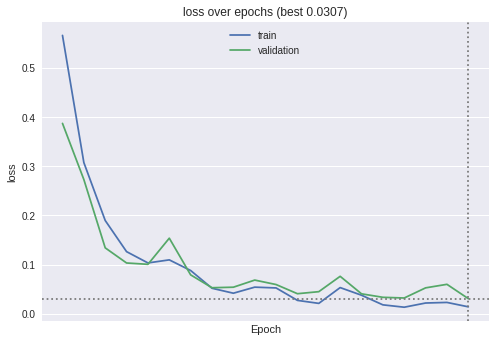

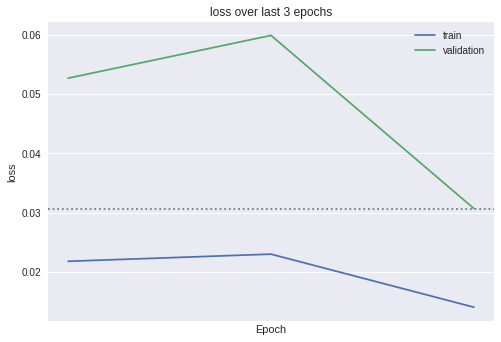

In [56]:
pretty_plot(history, 'loss', lambda x: np.argmin(x))

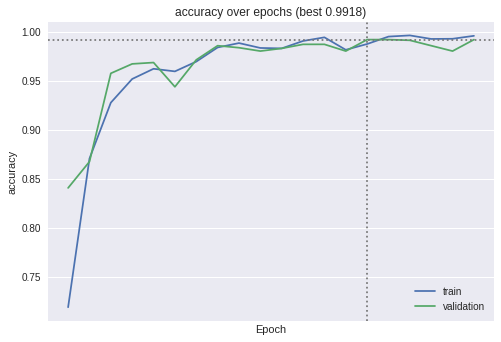

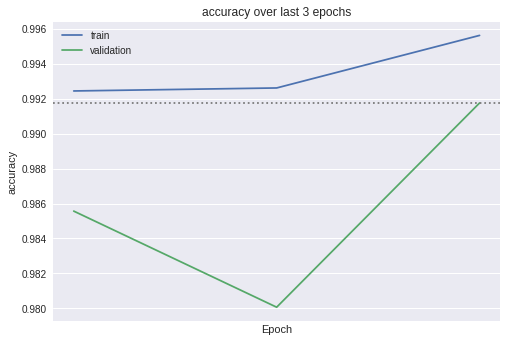

In [57]:
pretty_plot(history, 'accuracy', lambda x: np.argmax(x))

In [58]:
resnet_model.load_weights('weights.hdf5')
resnet_model.evaluate(X_ptbdbl_test, y_ptbdbl_test)

46/46 [==============================] - 0s 6ms/step - loss: 0.0164 - accuracy: 0.9952


[0.01638117991387844, 0.995192289352417]

Confusion matrix, without normalization
[[ 380    5]
 [   2 1069]]


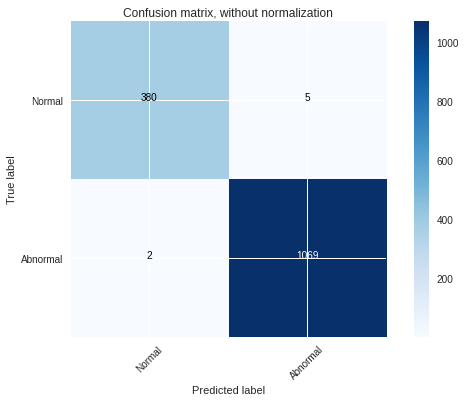

In [59]:
y_pred = (resnet_model.predict(X_ptbdbl_test) > 0.5).astype("int32")
# Compute confusion matrix
cnf_matrix = sklearn.metrics.confusion_matrix(y_ptbdb_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Normal', 'Abnormal'],
                      title='Confusion matrix, without normalization')

## ResNet MIT-BIH replication

In [60]:
X_mitbih_train, X_mitbih_val, y_mitbih_train, y_mitbih_val = train_test_split(mitbih_train.iloc[:,:-1].values, mitbih_train.iloc[:,-1].values, test_size=0.1, random_state=42)
X_mitbih_test = mitbih_test.iloc[:,:-1].values
y_mitbih_test = mitbih_test.iloc[:,-1].values

In [62]:
X_mitbih_train.shape

(78798, 187)

In [63]:
# The 1D convolutions expect an extra dimension in the input data 
X_mitbihl_train = np.expand_dims(X_mitbih_train, -1) ## (78798, 187, 1)
y_mitbihl_train = np.expand_dims(y_mitbih_train, -1)
X_mitbihl_val = np.expand_dims(X_mitbih_val, -1)
y_mitbihl_val = np.expand_dims(y_mitbih_val, -1)
X_mitbihl_test = np.expand_dims(X_mitbih_test, -1)
y_mitbihl_test = np.expand_dims(y_mitbih_test, -1)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


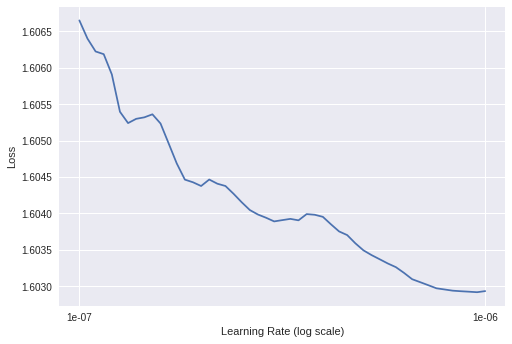

In [65]:
optimizer = keras.optimizers.Adam(lr=0.001)
model = get_resnet_model(5)  ## 5 categories
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

lr_finder = LRFinder(start_lr=1e-7, end_lr= 1e-06, max_steps=50, smoothing=0.6)
_ = model.fit(X_mitbihl_train, y_mitbihl_train, batch_size=256, epochs=5, callbacks=[lr_finder], verbose=False)
lr_finder.plot()

In [68]:
lr_schedule = CyclicalLearningRate(1e-5, 1e-3, step_size=step_size, scale_fn=lambda x: tf.pow(0.95,x))
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
m_resnet_model = get_resnet_model(5)

save_best_weights = ModelCheckpoint(filepath="weights.hdf5", verbose=0, save_best_only=True)

m_resnet_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = m_resnet_model.fit(X_mitbihl_train, y_mitbihl_train, validation_data=(X_mitbihl_val, y_mitbihl_val), 
                             shuffle=True, batch_size=128, epochs=20, callbacks=[save_best_weights])

Epoch 1/20
616/616 [==============================] - 9s 10ms/step - loss: 0.3276 - accuracy: 0.9154 - val_loss: 0.1587 - val_accuracy: 0.9548
Epoch 2/20
 14/616 [..............................] - ETA: 4s - loss: 0.1328 - accuracy: 0.9632

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


616/616 [==============================] - 5s 8ms/step - loss: 0.1320 - accuracy: 0.9649 - val_loss: 0.1721 - val_accuracy: 0.9513
Epoch 3/20
616/616 [==============================] - 5s 8ms/step - loss: 0.1032 - accuracy: 0.9716 - val_loss: 0.0839 - val_accuracy: 0.9751
Epoch 4/20
616/616 [==============================] - 5s 8ms/step - loss: 0.0844 - accuracy: 0.9767 - val_loss: 0.0805 - val_accuracy: 0.9766
Epoch 5/20
616/616 [==============================] - 5s 8ms/step - loss: 0.0726 - accuracy: 0.9801 - val_loss: 0.0852 - val_accuracy: 0.9758
Epoch 6/20
616/616 [==============================] - 5s 8ms/step - loss: 0.0661 - accuracy: 0.9816 - val_loss: 0.0668 - val_accuracy: 0.9789
Epoch 7/20
616/616 [==============================] - 5s 8ms/step - loss: 0.0618 - accuracy: 0.9827 - val_loss: 0.0627 - val_accuracy: 0.9804
Epoch 8/20
616/616 [==============================] - 5s 8ms/step - loss: 0.0549 - accuracy: 0.9845 - val_loss: 0.0836 - val_accuracy: 0.9761
Epoch 9/20
616/61

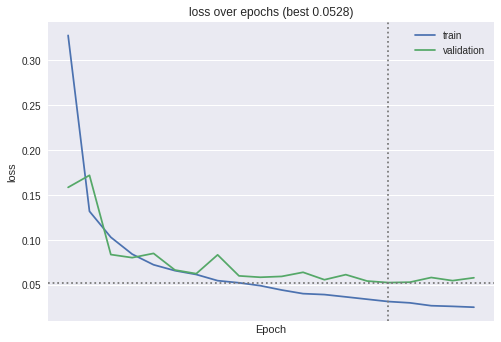

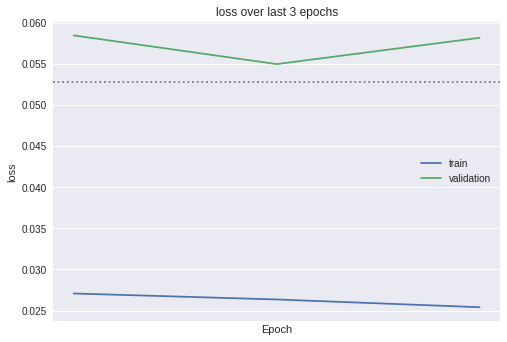

In [69]:
pretty_plot(history, 'loss', lambda x: np.argmin(x))

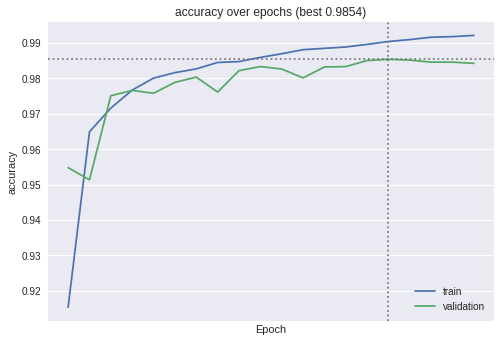

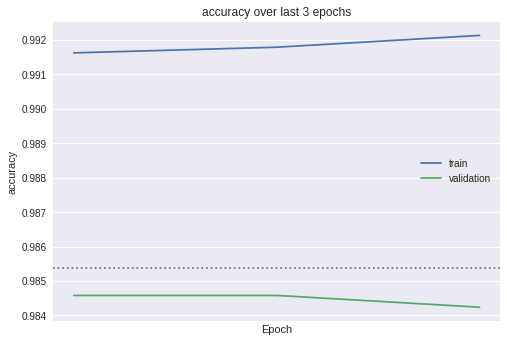

In [70]:
pretty_plot(history, 'accuracy', lambda x: np.argmax(x))

In [71]:
m_resnet_model.load_weights('weights.hdf5')
X_mitbih_test = m_resnet_model.evaluate(X_mitbihl_test, y_mitbihl_test) ## loss: 0.0578 - accuracy: 0.9851

685/685 [==============================] - 3s 4ms/step - loss: 0.0578 - accuracy: 0.9851


In [72]:
y_pred = tf.argmax(m_resnet_model.predict(X_mitbihl_test), axis=-1)
# Compute confusion matrix
cnf_matrix = sklearn.metrics.confusion_matrix(y_mitbih_test, y_pred)
np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[18044    39    23     4     8]
 [  115   427     9     2     3]
 [   44     5  1385    12     2]
 [   21     1    15   125     0]
 [   18     3     3     0  1584]]


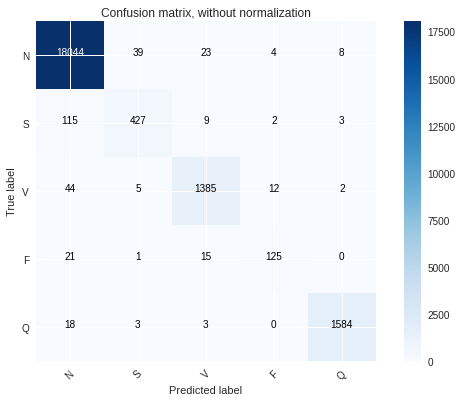

In [73]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['N', 'S', 'V', 'F', 'Q'],
                      title='Confusion matrix, without normalization')

# Transfer learning application

In [74]:
m_resnet_model.summary()  # best model summary

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 187, 1)]     0           []                               
                                                                                                  
 conv1d_55 (Conv1D)             (None, 183, 32)      192         ['input_6[0][0]']                
                                                                                                  
 conv1d_56 (Conv1D)             (None, 183, 32)      5152        ['conv1d_55[0][0]']              
                                                                                                  
 re_lu_50 (ReLU)                (None, 183, 32)      0           ['conv1d_56[0][0]']              
                                                                                            

In [75]:
# Reuse the MIT trained model, except the last three layers
def get_transfer_model(model):
  model.trainable = False
  model_input = model.inputs
  model_output = model.layers[-4].output  ### except the last three layers

  X = keras.layers.Dense(32, activation='relu')(model_output)  ## add 3 new layers
  X = keras.layers.Dense(32, activation='relu')(X)
  out = keras.layers.Dense(1, activation='sigmoid')(X)

  transfer_model = keras.Model(inputs=model_input, outputs=out)
  return transfer_model

In [76]:
get_transfer_model(m_resnet_model).summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 187, 1)]     0           []                               
                                                                                                  
 conv1d_55 (Conv1D)             (None, 183, 32)      192         ['input_6[0][0]']                
                                                                                                  
 conv1d_56 (Conv1D)             (None, 183, 32)      5152        ['conv1d_55[0][0]']              
                                                                                                  
 re_lu_50 (ReLU)                (None, 183, 32)      0           ['conv1d_56[0][0]']              
                                                                                            

In [77]:
optimizer = keras.optimizers.Adam(lr=0.001)
transfer_model = get_transfer_model(m_resnet_model)
save_best_weights = ModelCheckpoint(filepath="tweights.hdf5", verbose=0, save_best_only=True)
transfer_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
history = transfer_model.fit(X_ptbdbl_train, y_ptbdbl_train, validation_data=(X_ptbdbl_val, y_ptbdbl_val), 
                             shuffle=True, batch_size=128, epochs=30, callbacks=[save_best_weights])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/30
91/91 [==============================] - 2s 9ms/step - loss: 0.5399 - accuracy: 0.7626 - val_loss: 0.3857 - val_accuracy: 0.8213
Epoch 2/30
22/91 [======>.......................] - ETA: 0s - loss: 0.3797 - accuracy: 0.8292

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


91/91 [==============================] - 1s 6ms/step - loss: 0.3603 - accuracy: 0.8478 - val_loss: 0.3257 - val_accuracy: 0.8619
Epoch 3/30
91/91 [==============================] - 1s 6ms/step - loss: 0.3106 - accuracy: 0.8748 - val_loss: 0.2890 - val_accuracy: 0.8880
Epoch 4/30
91/91 [==============================] - 1s 6ms/step - loss: 0.2815 - accuracy: 0.8894 - val_loss: 0.2766 - val_accuracy: 0.8928
Epoch 5/30
91/91 [==============================] - 1s 6ms/step - loss: 0.2544 - accuracy: 0.9035 - val_loss: 0.2756 - val_accuracy: 0.8880
Epoch 6/30
91/91 [==============================] - 1s 6ms/step - loss: 0.2393 - accuracy: 0.9099 - val_loss: 0.2419 - val_accuracy: 0.8990
Epoch 7/30
91/91 [==============================] - 1s 6ms/step - loss: 0.2227 - accuracy: 0.9146 - val_loss: 0.2152 - val_accuracy: 0.9127
Epoch 8/30
91/91 [==============================] - 1s 6ms/step - loss: 0.2127 - accuracy: 0.9179 - val_loss: 0.2059 - val_accuracy: 0.9189
Epoch 9/30
91/91 [=============

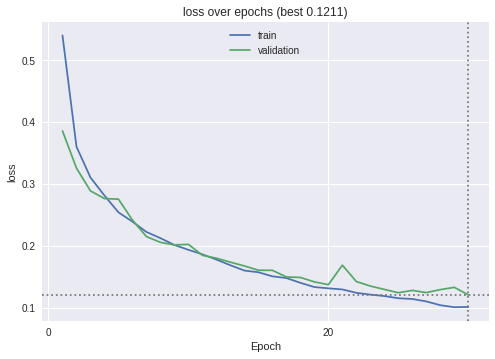

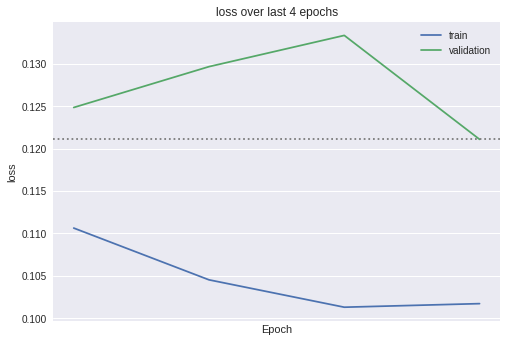

In [78]:
pretty_plot(history, 'loss', lambda x: np.argmin(x))

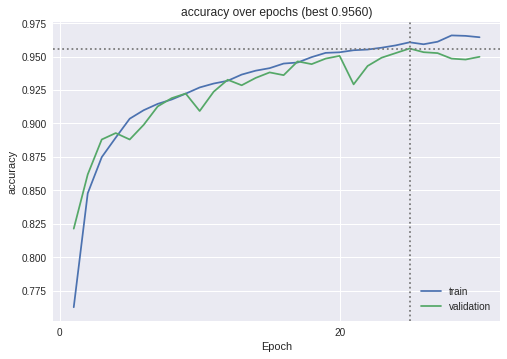

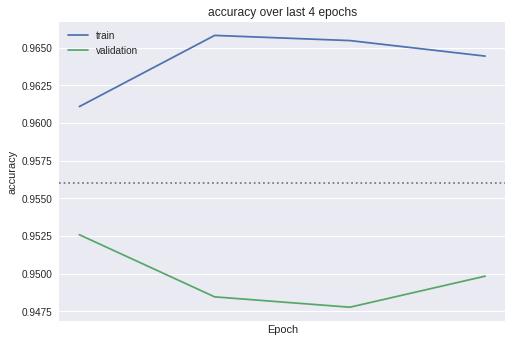

In [79]:
pretty_plot(history, 'accuracy', lambda x: np.argmax(x))

In [80]:
transfer_model.load_weights('tweights.hdf5')
transfer_model.evaluate(X_ptbdbl_test, y_ptbdb_test) ## [0.12586623430252075, 0.9539835453033447]

46/46 [==============================] - 0s 4ms/step - loss: 0.1259 - accuracy: 0.9540


[0.12586623430252075, 0.9539835453033447]

In [81]:
y_pred = (transfer_model.predict(X_ptbdbl_test) >= 0.5).astype("int32")
# Compute confusion matrix
cnf_matrix = sklearn.metrics.confusion_matrix(y_ptbdb_test, y_pred)
np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[ 347   38]
 [  29 1042]]


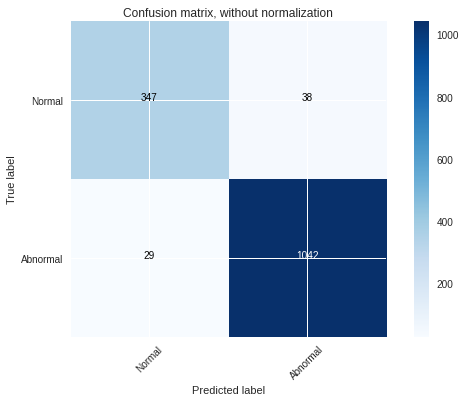

In [82]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Normal', 'Abnormal'],
                      title='Confusion matrix, without normalization')